## Conscious perception of natural images is constrained by category-related visual features
Daniel Lindh (1,2), Ilja Sligte (2), Sara Assecondi (1), Kimron Shapiro (1), Ian Charest (1)

1 University of Birmingham

2 University of Amsterdam


This notebook contains code for plots generated for this publication

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, glob
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import spearmanr, ttest_1samp, pearsonr, ttest_rel, wilcoxon
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as smm
import itertools
from scipy.stats import pointbiserialr as pbs

In [5]:
data_folder = '../data'
CNN_folder = '../DCNN_features'
stats_folder = '../stats_results'
plot_folder = '../plots'
layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']
AB = np.loadtxt(os.path.join(data_folder, 'ABmag_allsubs.txt'))
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set(style="ticks", font_scale = 2)

## Plot standard AB effect

In [6]:
# Read data, rename columns
df = pd.read_csv(os.path.join(data_folder, 'behavioral_data.csv'))

In [44]:
# Calculate ABM per image
df2 = df.groupby(['subject', 'T2', 'Lag'], as_index=False).mean()
df2 = df2[df2.subject != 9] # remove subject 9 because not having enough trials on one of the images
lag2 = df2[df2['Lag']=='Lag 2'] # get lag 2 performance per image
lag8 = df2[df2['Lag']=='Lag 8'] # get lag 8 performance per image
lag2['ABM'] = lag8['HitT2'].values - lag2['HitT2'].values # subtract lag2 performance frmo lag 8

lag2.to_csv('../data/ABM_subs.csv', index=False) # save

/Users/daniel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


/Users/daniel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  
/Users/daniel/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


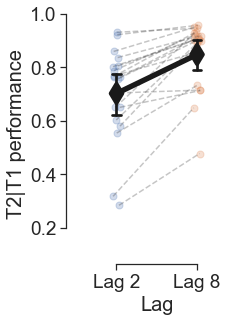

In [5]:
# group data for plotting
df_plot = df.groupby(('subject', 'Lag'), as_index=False).mean()


plt.figure(figsize=(4,5))

# plot individual subjects, with different colors per lag
# and dashed line between subjects
for s in np.unique(df_plot.subject):
    sdf = df_plot[df_plot.subject==s]
    lag2 = sdf[sdf.Lag == 'Lag 2']['HitT2'].values[0]
    lag8 = sdf[sdf.Lag == 'Lag 8']['HitT2'].values[0]

    jitter = (np.random.randint(100)-50)/1000
    markersize=7
    x = (0+jitter, 1+jitter)
    plt.plot(x[0], lag2, color=sns.color_palette()[0], marker='o', alpha=0.25, markersize=markersize)
    plt.plot(x[1], lag8, color=sns.color_palette()[1], marker='o', alpha=0.25, markersize=markersize)
    plt.plot(x, (lag2, lag8), '--k', alpha=0.25)

#plt.setp(ax.lines, zorder=100)
# plot mean on top of subjects
ax = sns.pointplot(x='Lag', y='HitT2', color='k',
                   data=df_plot, zorder=1, ci=95,
                   capsize=.1, markers="d", scale=2)
plt.setp(ax.collections, zorder=100, label="")
plt.ylim((0.1, 1.0))
sns.despine(offset=10, trim=True)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.yticks(size=19)
# Set labels
plt.xlabel('Lag', size=20)
plt.ylabel('T2|T1 performance', size=20)
plt.xticks(range(2), ('Lag 2', 'Lag 8'), size=19)

plt.tight_layout()
#plt.show()
save_to = os.path.join(plot_folder, 'Lag_performance.pdf')
plt.savefig(save_to)

## Plot AB effects across categories

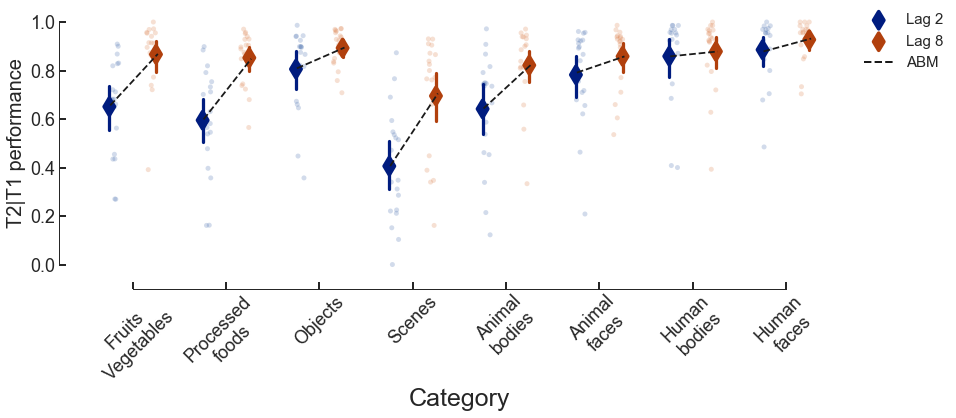

In [58]:
df_plot = df.groupby(('Lag', 'subject', 'Category'), as_index=False).mean()
categories = ('Fruits\nVegetables', 'Processed\nfoods',
              'Objects', 'Scenes', 'Animal\nbodies', 
              'Animal\nfaces', 'Human\nbodies', 'Human\nfaces')
plt.figure(figsize=(14,5))
# Show each observation with a scatterplot
ax = sns.stripplot(x="Category", y="HitT2", hue="Lag",
              data=df_plot, dodge=True, jitter=True,
              alpha=.25, zorder=1, order = categories)
ax.legend_.remove()
# Show the conditional means
ax = sns.pointplot(x="Category", y="HitT2", hue="Lag",
              data=df_plot, dodge=.5, join=False, palette="dark",
              markers="d", scale=1.5, ci=95, order = categories)


# add dashed line between lags
jdf = df.groupby(('Lag', 'Category'), as_index=False).mean()
for i, cat in enumerate(categories):
    # there is an offset to the middle of the diamond, hence -0.025
    lag2 = jdf[(jdf.Category == cat) & (jdf.Lag=='Lag 2')]['HitT2'].values-0.025 
    lag8 = jdf[(jdf.Category == cat) & (jdf.Lag=='Lag 8')]['HitT2'].values-0.025
    x = np.array([-.24, .27]) + i
    if cat == 'Objects' or cat == 'Human\nfaces':
        lag8 += 0.015
    plt.plot(x, (lag2, lag8), '--k')

# Get legends and add our own
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0], color='k', lw=2, linestyle='--'))
labels.append('ABM')

# When creating the legend, only use the last elements
# to effectively remove the first two.
l = plt.legend(handles[2:], labels[2:],
               bbox_to_anchor=(1.01, 1), loc=2,
               borderaxespad=0., frameon=False,
               prop={'size': 15})

sns.despine(offset=10, trim=True)

plt.ylabel('T2|T1 performance', size=20)
plt.xlabel('Category', size=25)

plt.xticks(rotation=45, size=18)
plt.yticks(size=18)
sns.set_style({"xtick.direction": "in","ytick.direction": "in", "font_scale": 7, 'linewidth': 10})
plt.tick_params(width=2, length=7)

save_to = os.path.join(plot_folder, 'category_performance.pdf')
plt.savefig(save_to, bbox_inches='tight')

In [140]:
## Save category AB for stats
df_save = df[['subject', 'Category', 'Lag', 'HitT2']]
df_save = df_save.groupby(('subject', 'Category', 'Lag'), as_index=False).mean()
s = ['{0} ({1})'.format(cat, lag).replace('\n', ' ') for cat, lag in zip(df_save['Category'], df_save['Lag'])]
df_save['Condition'] = s
df_save = df_save.groupby(('subject', 'Condition'), as_index=False).mean()
df_save = df_save.pivot(index='subject', columns='Condition', values='HitT2')
df_save.to_csv(os.path.join(data_folder, 'category_lag.csv'), index=False)

## Plot AB for animacy

In [62]:
df_plot = df[df.Category != 'Scenes'].copy()
df_plot['Animate'] = ['Animate' if x > 23 else 'Inanimate' for x in df_plot['T2']]

df_plot = df_plot.groupby(('subject', 'Animate', 'Lag'), as_index=False).mean()

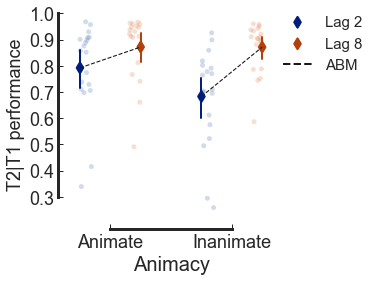

In [147]:

plt.figure(figsize=(4,4))
dodge = 0.5
# Show each observation with a scatterplot
ax = sns.stripplot(x="Animate", y="HitT2", hue="Lag",
              data=df_plot, dodge=dodge/4, jitter=True,
              alpha=.25, zorder=1)
ax.legend_.remove()
# Show the conditional means
ax = sns.pointplot(x="Animate", y="HitT2", hue="Lag",
              data=df_plot, dodge=dodge, join=False, palette="dark",
              markers="d", scale=1.5, ci=95)


# Join between lags
jdf = df_plot.groupby(('Lag', 'Animate'), as_index=False).mean()
for i, cat in enumerate(('Animate','Inanimate')):
    lag2 = jdf[(jdf.Animate == cat) & (jdf.Lag=='Lag 2')]['HitT2'].values
    lag8 = jdf[(jdf.Animate == cat) & (jdf.Lag=='Lag 8')]['HitT2'].values
    x = np.array([-(dodge/2), dodge/2]) + i
    plt.plot(x, (lag2, lag8), '--k')

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0], color='k', lw=2, linestyle='--'))
labels.append('ABM')
l = plt.legend(handles[2:], labels[2:],
               bbox_to_anchor=(1.01, 1), loc=2,
               borderaxespad=0., frameon=False,
               prop={'size': 15})


sns.despine(offset=10, trim=True)

plt.ylabel('T2|T1 performance', size=18)
plt.xlabel('Animacy', size=20)

#paper_rc = {'lines.linewidth': 1.2, 'lines.markersize': 10}
#sns.set_context("paper", rc = paper_rc)

sns.set_style({"xtick.direction": "in","ytick.direction": "in", "font_scale": 7})
plt.xticks(size=18)
plt.yticks(size=18)

plt.tight_layout()

save_to = os.path.join(plot_folder, 'animal_performance.pdf')
plt.savefig(save_to, bbox_inches='tight')

In [314]:
## Save category AB for stats
df_save = df_plot[['subject', 'Animate', 'Lag', 'HitT2']]
df_save = df_save.groupby(('subject', 'Animate', 'Lag'), as_index=False).mean()
s = ['{0} ({1})'.format(cat, lag).replace('\n', ' ') for cat, lag in zip(df_save['Animate'], df_save['Lag'])]
df_save['Condition'] = s
df_save = df_save.groupby(('subject', 'Condition'), as_index=False).mean()
df_save = df_save.pivot(index='subject', columns='Condition', values='HitT2')
df_save.to_csv(os.path.join(data_folder, 'Animate_lag.csv'), index=False)

## Plot Mean Absolute Error (MAE) between predicted and actual AB magnitude

In [10]:
df = pd.DataFrame()
for layer in layers:
    print('Layer', layer)
    layer_df = pd.DataFrame()

    errors = []
    for sub in range(AB.shape[0]):
        y_true = AB[sub, :]
        # first iteration is the un-permutated (real) prediction
        perm = glob.glob(os.path.join(data_folder, f'test_{layer}_prediction.npy'))[0]
        perm = np.load(perm)
        y_pred = perm[sub, :]
        errors.append(MAE(y_true, y_pred))
    layer_df['MAE'] = errors
    layer_df['Layer'] = [layer]*len(layer_df)
    layer_df['Subject'] = np.arange(len(layer_df))

    df = pd.concat((df, layer_df))

# Save for doing stats
df_save = df.pivot(index='Subject', columns='Layer', values='MAE')
df_save.to_csv(os.path.join(data_folder, 'MAE_per_layer.csv'), index=False)

Layer conv1
Layer conv2
Layer conv3
Layer conv4
Layer conv5
Layer fc6
Layer fc7
Layer fc8


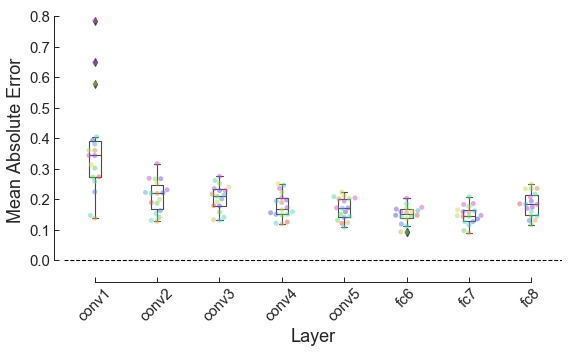

In [11]:
sns.set(style="ticks", font_scale = 2)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
paper_rc = {'lines.linewidth': 1.1, 'lines.markersize': 10}
sns.set_context("paper", rc = paper_rc)
cmap = sns.color_palette("hls", 20)
fig = plt.figure(figsize=(8,5))
# plot
sns.boxplot(x='Layer', y='MAE', data=df, boxprops={'facecolor':'none'}, width=0.2)
ax = sns.swarmplot(x='Layer', y='MAE', hue='Subject', data=df, palette=cmap, edgecolor='black', alpha=0.5)
ax.legend_.remove()

# add horizontal line at 0
plt.axhline(y=0.0, color='black', linestyle='--')
sns.despine(offset=10, trim=True)
#plt.xticks(np.arange(len(layers)), layers, rotation=45, size=15)

#plt.ylim([-0.05, 0.2])
plt.yticks(size=15)
# Set labels
plt.xlabel('Layer', size=18)
plt.ylabel('Mean Absolute Error', size=18)
plt.xticks(size=15, rotation=45)
#plt.title('Correlation between T2 performance and ', size=15)
plt.tight_layout()

# Save
save_to = os.path.join(plot_folder, 'layer_MAE.pdf')
plt.savefig(save_to, bbox_inches='tight')

## Plot fc7 prediction per image

In [15]:
layer = 'fc7'
layer_path = os.path.join(data_folder, f'test_{layer}_prediction.npy')
y_hat = np.load(layer_path)
#AB = np.loadtxt(os.path.join(data_folder, 'ABmag_allsubs.txt'))
AB_df = pd.read_csv('../data/ABM_subs.csv')
AB = np.zeros((len(np.unique(AB_df['subject'])), 48))

for x, s in enumerate(np.unique(AB_df['subject'])):
    AB[x, :] =  AB_df[AB_df['subject'] == s]['ABM'].values
# n subjects and images
ns  = AB.shape[0]
ni = AB.shape[1]

df_3 = pd.DataFrame()
for sub in range(ns):
    tmp = pd.DataFrame()
    tmp['subject'] = [f'sub-{sub:02d}']*ni
    tmp['prediction'] = y_hat[sub, :]
    tmp['ABM'] = AB[sub, :]
    tmp['image'] = np.arange(ni)
    
    df_3 = pd.concat((df_3, tmp))
    
tmp = df_3.groupby(('image'), as_index=False).mean()
r, p = pearsonr(tmp['prediction'], tmp['ABM'])

print(f'Layer: {layer}')
print(f'pearson = {r:.4f}')
print(f'variance explained = {r**2:.4f}')


Layer: fc7
pearson = 0.6849
variance explained = 0.4690


/Users/daniel/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


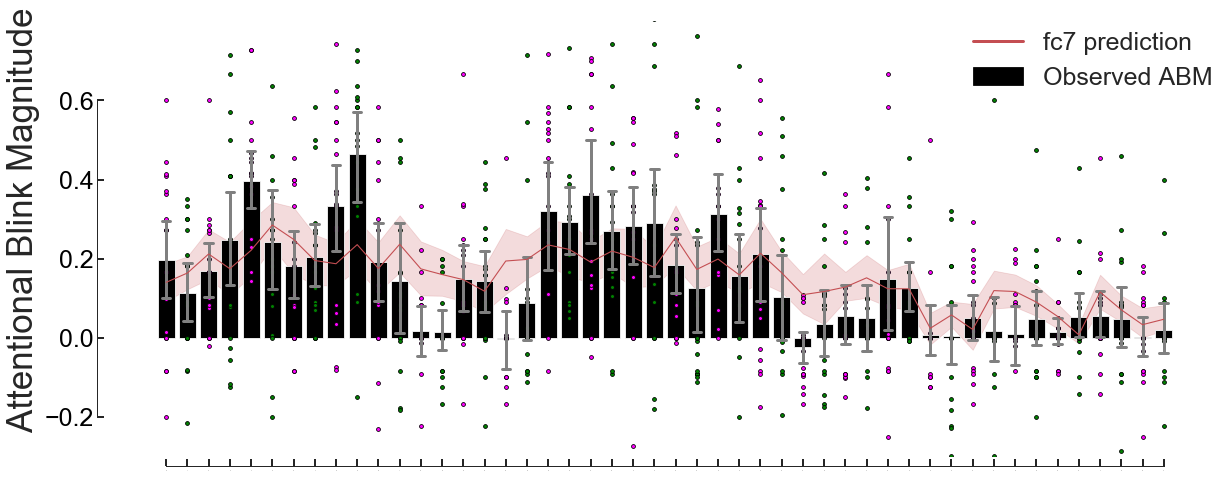

In [16]:
plt.figure(figsize=(20,8))

sns.barplot(x='image', y='ABM', data=df_3, ci=95, color='black', errcolor='grey', errwidth=3, capsize=0.4, zorder=1)
#ax = sns.stripplot(x='image', y='ABM', hue='subject', data=df_3)
#sns.stripplot(x='image', y='ABM', hue='subject', data=df_3)



colors = ['magenta', 'green']
for i in range(48):
    a = df_3[df_3['image']==i]
    x = [i]*18
    plt.scatter(x, a['ABM'].values, color=colors[i%2],
                edgecolors='black', zorder=100, s=15)
    
ax = sns.lineplot(x='image', y='prediction', data=df_3, ci=95,markers='d', color ='r', zorder=50)
plt.setp(ax.lines, zorder=300)

plt.tick_params(width=2, length=7)
#plt.axhline(y=0.0, color='black', linestyle='--')
#plt.xlim(-.5, 47.5)
plt.ylim(-.3, 0.8)
sns.despine(offset=10, trim=True)
plt.xticks(size=0)
plt.yticks(size=25, color='black')
plt.xlabel('')
plt.ylabel('    Attentional Blink Magnitude', size=35)
plt.rcParams['axes.linewidth'] = 3

# Lets add legends
black_patch = mpatches.Patch(color='black')
handles = [Line2D([0], [0], color='r', lw=3, linestyle='-'), black_patch]
labels =['fc7 prediction', 'Observed ABM']


l = plt.legend(handles, labels, loc=1,
               borderaxespad=0., frameon=False,
               prop={'size': 25})

#plt.tight_layout()

save_to = os.path.join(plot_folder, 'fc_ABM_pred.pdf')
plt.savefig(save_to, bbox_inches='tight')

r = 0.685
r2 = 0.469


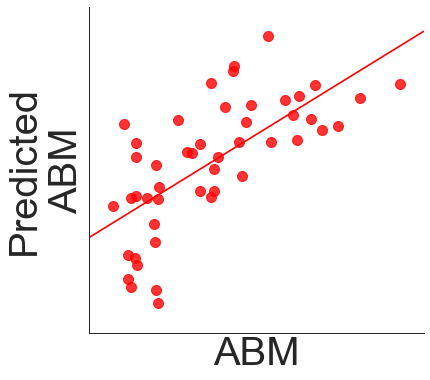

In [17]:
tmp = df_3.groupby(('image'), as_index=False).mean()

paper_rc = {'lines.linewidth': 1.1, 'lines.markersize': 10}
sns.set_context("paper", rc = paper_rc)

plt.figure(figsize=(6,6))
sns.regplot(x='ABM', y='prediction', data=tmp, color='red', ci=None)

sns.set_style({"xtick.direction": "in","ytick.direction": "in", "font_scale": 15})
sns.despine()

plt.xlabel('ABM', size=40)
plt.ylabel('Predicted\nABM', size=40)
plt.xticks([],size=35)
plt.yticks([], size=35)
# correlate 
r, p = pearsonr(tmp['ABM'], tmp['prediction'])
print(f'r = {r:.3f}\nr2 = {r**2:.3f}')

save_to = os.path.join(plot_folder, 'fc_ABM_pred_linplot.pdf')
#plt.savefig(save_to, bbox_inches='tight')

plt.show()

In [19]:
list_mean = []
data_path = '../data'
list_std = []
for li, layer in enumerate(layers):
    # load layer data for permutations and predictions
    load_path = os.path.join(data_path, f'{layer}_prediction_permutations.npy')
    perm = np.load(load_path)
    load_path = os.path.join(data_path, f'test_{layer}_prediction.npy')
    sub_pred = np.load(load_path)
    
    n_perm = perm.shape[0]
    maes = []
    perm_maes = np.zeros((18, n_perm))
    for sub in range(18):
        perm_sub = perm[:, sub, :]
        pred_sub = sub_pred[sub, :]
        maes.append(MAE(AB[sub, :], pred_sub))
        for i in range(perm_sub.shape[0]):
            perm_maes[sub, i] = MAE(AB[sub, :], perm_sub[i, :])
    perm_mae = perm_maes.mean(0)
    pred_mae = np.mean(maes)
    pred_std = np.std(maes)
    p = 1 - (sum(perm_mae > pred_mae) / n_perm)
    
    list_mean.append(pred_mae)
    list_std.append(pred_std)

In [40]:
for li, layer in enumerate(layers):
    print(layer)
    print(f'mean = {list_mean[li]:.4f}')
    print(f'std = {list_std[li]:.4f}\n')

conv1
mean = 0.3695
std = 0.1667

conv2
mean = 0.2203
std = 0.0571

conv3
mean = 0.2115
std = 0.0424

conv4
mean = 0.1862
std = 0.0406

conv5
mean = 0.1799
std = 0.0466

fc6
mean = 0.1593
std = 0.0331

fc7
mean = 0.1593
std = 0.0342

fc8
mean = 0.1910
std = 0.0476



  0%|          | 0/8 [00:00<?, ?it/s]/Users/daniel/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
100%|██████████| 8/8 [08:01<00:00, 52.96s/it]


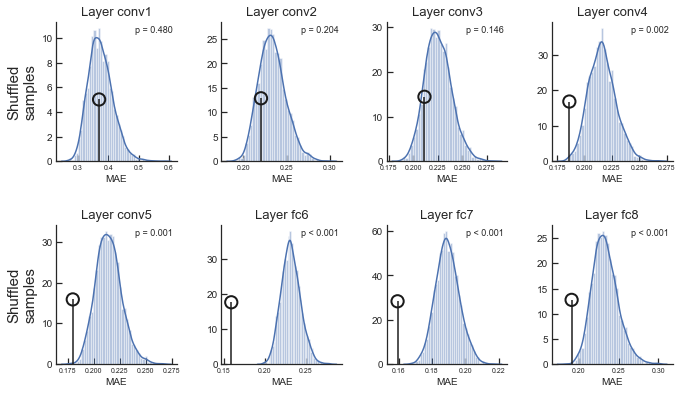

In [20]:
# PERMUTATION TEST DISTRIBUTION
import os
import numpy as np
from sklearn.metrics import mean_absolute_error as MAE
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from matplotlib.lines import Line2D
import pandas as pd
from tqdm import tqdm

"""
Plots the permutation distribution of MAE per layer
"""

# set plotting styles
sns.set(style="ticks", font_scale = 2)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
paper_rc = {'lines.linewidth': 1.1, 'lines.markersize': 10}

# load data
data_path = '../data'
stats_path = '../stats_results'

AB_df = pd.read_csv('../data/ABM_subs.csv')
AB = np.zeros((len(np.unique(AB_df['subject'])), 48))
for x, s in enumerate(np.unique(AB_df['subject'])):
    AB[x, :] =  AB_df[AB_df['subject'] == s]['ABM'].values

layers = ('conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8')
#layers = ['conv1', 'conv2']

# Initiate subplots
fig, axes = plt.subplots(2, 4,sharey=False,sharex=False, figsize=(10,6))
axes = axes.ravel()
p_dict = {}

# array to store MAE values per subject for each layer
MAE_arr = np.zeros((AB.shape[0], len(layers)))
p_arr = np.zeros((AB.shape[0], len(layers)))
M_SE = pd.DataFrame()

list_mean = []
list_std = []
df_perm = pd.DataFrame()
for li, layer in enumerate(tqdm(layers)):
    # load layer data for permutations and predictions
    load_path = os.path.join(data_path, f'{layer}_prediction_permutations.npy')
    perm = np.load(load_path)
    load_path = os.path.join(data_path, f'test_{layer}_prediction.npy')
    sub_pred = np.load(load_path)
    
    n_perm = perm.shape[0]
    maes = []
    perm_maes = np.zeros((18, n_perm))
    for sub in range(18):
        perm_sub = perm[:, sub, :]
        pred_sub = sub_pred[sub, :]
        maes.append(MAE(AB[sub, :], pred_sub))
        for i in range(perm_sub.shape[0]):
            perm_maes[sub, i] = MAE(AB[sub, :], perm_sub[i, :])
    perm_mae = perm_maes.mean(0)
    pred_mae = np.mean(maes)
    pred_std = np.std(maes)
    p = 1 - (sum(perm_mae > pred_mae) / n_perm)

    list_mean.append(pred_mae)
    list_std.append(pred_std)
    
    mae_std = perm_mae.std()
    mae_median = np.mean(perm_mae)

    # plot
    sns.distplot(perm_mae, ax = axes[li])
    x,y = axes[li].get_lines()[0].get_data()
    axes[li].scatter(pred_mae, max(y)/2, s=150, facecolors='none',
                     edgecolors='k', linewidths=2, zorder=20)
    axes[li].vlines(pred_mae, 0, max(y)/2, zorder=21)

    axes[li].set_xlabel('MAE', size=10)
    if li == 0 or li ==4:
        axes[li].set_ylabel('Shuffled\nsamples', size=15)
    #axes[li].set_ylim((0, 200))

    axes[li].set_title('Layer {0}'.format(layer), size=13)
    #axes[li].set_yticks(size=14)
    axes[li].tick_params(axis='y', which='major', labelsize=10)
    axes[li].tick_params(axis='x', which='major', labelsize=8)

    # add p-value legend
    handles = [Line2D([0], [0], color='k', lw=0)]
    labels = [f'p = {p:.3f}']
    if p > 1:
        labels = ['p = 1.0']
    elif p < 0.001:
        labels = ['p < 0.001']
    l = axes[li].legend(handles, labels, loc=1,
                   borderaxespad=0., frameon=False,
                   prop={'size': 9})
    sns.despine(ax=axes[li])
    
    # save MAEs to dataframe
    tmp = pd.DataFrame()
    tmp['MAE'] = maes
    tmp['Layer'] = [layers[li]] * len(tmp)
    tmp['Subject'] = np.arange(len(tmp))
    
    df_perm = pd.concat((df_perm, tmp))
plt.tight_layout()

# fix x-axes
for i in range(8):
    axes[i].tick_params(axis='x', which='major', bottom='on',
                        top='off', labelbottom='on', labelsize=7)
fig.tight_layout()

# save plot
#plt.show()
plt.savefig('../plots/layer_distribution_new.png', dpi=300)

In [23]:
save_df = df_perm.pivot(index='Subject', columns='Layer', values='MAE')
save_df.to_csv('../stats_results/layer_MAE')
save_df

Layer,conv1,conv2,conv3,conv4,conv5,fc6,fc7,fc8
Subject,,,,,,,,
0,0.275707,0.186830,0.187690,0.129254,0.133325,0.156065,0.149348,0.187556
1,0.387547,0.258860,0.251782,0.225073,0.240729,0.180680,0.196281,0.284924
2,0.131648,0.131539,0.137079,0.123621,0.123024,0.093484,0.092955,0.128442
3,0.310097,0.249409,0.240333,0.248503,0.216999,0.176698,0.181277,0.247764
4,0.381641,0.230589,0.241959,0.212660,0.284381,0.200826,0.198736,0.280758
5,0.573173,0.266301,0.245985,0.217663,0.198333,0.164065,0.171833,0.236428
6,0.268063,0.140640,0.156663,0.148371,0.130791,0.093207,0.096692,0.118935
7,0.306156,0.193059,0.215397,0.159674,0.160326,0.155333,0.154262,0.152071
8,0.406267,0.224899,0.264196,0.246001,0.207240,0.183201,0.208449,0.214156


## Plot heatmap for comparison between layers

In [4]:
# PERMUTATION TEST DISTRIBUTION
import os
import numpy as np
from sklearn.metrics import mean_absolute_error as MAE
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from matplotlib.lines import Line2D
import pandas as pd

"""
Plots the permutation distribution of MAE per layer
"""

# set plotting styles
sns.set(style="ticks", font_scale = 2)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
paper_rc = {'lines.linewidth': 1.1, 'lines.markersize': 10}

# load data
data_path = '../data'
stats_path = '../stats_results'
AB = np.loadtxt('../data/ABmag_allsubs.txt')
AB_ = AB.mean(0)
layers = ('conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8')
#layers = ['conv1', 'conv2']

p_dict = {}

# array to store MAE values per subject for each layer
MAE_arr = np.zeros((AB.shape[0], len(layers)))
p_arr = np.zeros((AB.shape[0], len(layers)))
M_SE = pd.DataFrame()
perm_dists = []
for li, layer in enumerate(layers):
    # load layer data for permutations and predictions
    load_path = os.path.join(data_path, f'{layer}_prediction_permutations.npy')
    perm = np.load(load_path)
    load_path = os.path.join(data_path, f'{layer}_prediction.npy')
    sub_pred = np.load(load_path)

    for s in range(AB.shape[0]):
        y = AB[s, :]
        sub_perm = perm[:,s,:]
        pred_mae = MAE(y, sub_pred[s,:])

        mae_list = []
        # iterate over the permutations and get the MAE
        for i in range(sub_perm.shape[0]):
            mae_list.append(MAE(y, sub_perm[i, :]))
        # calculate p-value
        p = sum(pred_mae>mae_list)/sub_perm.shape[0]
        if p < 0.05:
            if f'sub—{s}' not in p_dict.keys():
                p_dict[f'sub—{s}'] = []
            p_dict[f'sub—{s}'].append(layer)
        # store MAE and p-value
        MAE_arr[s, li] = pred_mae
        p_arr[s, li] = p

    # plot distribution of the mean permuted mae across participants
    # for the average ABM
    perm_ = perm.mean(1)
    mae_list = []
    for i in range(perm.shape[0]):
        mae_list.append(MAE(AB_, perm_[i, :]))
    mae_list = np.array(mae_list)

    pred_mae = MAE(AB_, sub_pred.mean(0))
    p = (sum(pred_mae>mae_list)/perm.shape[0])*len(layers)

    mae_std = mae_list.std()
    mae_median = np.mean(mae_list)
    
    perm_dists.append(mae_list)


In [21]:
layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']
# define possible layer comparisons
combos = list(itertools.combinations(range(8), 2))
alpha = 0.05
method = 'b'
p_vals = np.eye(8)
t_vals = np.eye(8)
mean_diff = np.zeros((8,8))

for l1, l2 in combos:
    layerx = df_perm[df_perm.Layer==layers[l1]]['MAE'].values
    layery = df_perm[df_perm.Layer==layers[l2]]['MAE'].values
    t, p = ttest_rel(layery, layerx)
    p_vals[l1, l2] = p
    t_vals[l1, l2] = t
    mean_diff[l1, l2] = layerx.mean()- layery.mean()
    if l1 == 6 or l2 == 6:#p*29 < 0.05:
        print(f'Layer 1: {l1}\nLayer 2: {l2}')
        print(f'Diff: {mean_diff[l1, l2]}')
        print(f't = {t:.4f}')
        print(f'p = {p:.6f}\n')
        

methods = 'bonferroni'
pval_raw = p_vals[np.triu_indices(8, 1)].flatten()
p_vals[np.triu_indices(8, 1)] = smm.multipletests(pval_raw, alpha=alpha, method=method)[:2][1]

Layer 1: 0
Layer 2: 6
Diff: 0.21021905102108454
t = -5.8269
p = 0.000020

Layer 1: 1
Layer 2: 6
Diff: 0.06104599008618544
t = -6.7508
p = 0.000003

Layer 1: 2
Layer 2: 6
Diff: 0.05218776477706258
t = -11.8776
p = 0.000000

Layer 1: 3
Layer 2: 6
Diff: 0.02689734920891526
t = -5.5902
p = 0.000033

Layer 1: 4
Layer 2: 6
Diff: 0.020641386858855332
t = -3.6418
p = 0.002017

Layer 1: 5
Layer 2: 6
Diff: -3.4888478375627585e-05
t = 0.0130
p = 0.989809

Layer 1: 6
Layer 2: 7
Diff: -0.031661349513212034
t = 4.6781
p = 0.000216



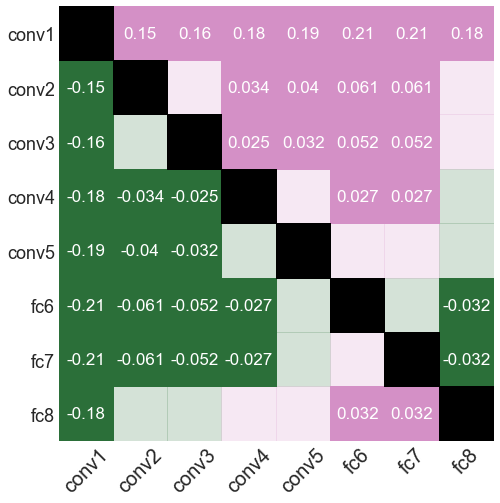

In [22]:
plt.figure(figsize=(10,8))
i_lower = np.tril_indices(8, -1)
i_upper = np.triu_indices(8, 1)

# repeat values of upper triangle on lower triangle
p_vals[i_lower] = p_vals.T[i_lower]
mean_diff[i_lower] = mean_diff.T[i_lower]*-1

# create masks
mask = p_vals > 0.05 #/len(combos) # Bonferroni correct alpha
#mask[i_upper] = True
# the faint color in the background is only masked on the upper triangle
alpha_mask = np.zeros((8,8)).astype(bool)
#alpha_mask[i_upper] = True

# define hot/cold color map
cmap = sns.color_palette("cubehelix", 2)


# plot the faint color in the backgroud
ax = sns.heatmap(mean_diff, robust=True, alpha=0.2, cbar=False, square=True,
                 vmin=-0.01, vmax=0.01, cmap=cmap, mask=alpha_mask)
# plot the main results
ax = sns.heatmap(mean_diff , robust=True, cbar=False, vmin=-0.01, square=True,
            vmax=0.01, annot=True, mask=mask, cmap=cmap, annot_kws={"size": 17},
           xticklabels=layers, yticklabels=layers)

# Lets make the diagonal black
cmap = [(0.0, 0.0, 0.0)] # black for the diagonal
sns.heatmap(np.eye(8), robust=True, cbar=False, cmap=cmap, square=True, 
            mask=~np.eye(8).astype(bool), xticklabels=layers, yticklabels=layers)

plt.xticks(rotation=45, size=20)
plt.yticks(rotation=0, size=18)
plt.tick_params(axis='both', which='major', left='off', bottom='off')

save_to = os.path.join(plot_folder, 'layer_MAE_comparison.pdf')
plt.savefig(save_to, bbox_inches='tight')

## Plot CNN target-target similarity and T2 accuracy

In [46]:
# read behavior
df = pd.read_csv(os.path.join(data_folder, 'behavioral_data.csv'))
lag = 'Lag 2'
df = df[df.Lag==lag]

In [47]:
#define layers
layers = ['conv1','conv2','conv3','conv4','conv5', 'fc6','fc7','fc8']
word_corr = np.load(os.path.join(data_folder, 'corr_word2vec.npy'))

df2 = pd.DataFrame()
for sub in np.unique(df.subject):

    print('Working sub:', sub, end='\r')
    tmp = df[df.subject == sub]

    sdf = pd.DataFrame()
    sub_df = pd.DataFrame()
    sub_df['HitT2'] = tmp.HitT2.values
    sub_df['subject'] = [sub]*len(sub_df)
    for layer in layers:
        layer_path = os.path.join(CNN_folder, f'correlated_features_{layer}.npy')
        # load units 
        corr_units = np.load(layer_path)
        
        corr = [corr_units[x-1, y-1] for x,y in zip(tmp.T1,tmp.T2)]
        bins = [np.percentile(corr, x) for x in np.arange(5,100,5)]
        
        sub_df[f'sim_{layer}'] = np.array(corr)
        sub_df[f'bins_{layer}'] = np.digitize(corr, bins)
    
    # Add for word2vec
    corr = [word_corr[x-1, y-1] for x,y in zip(tmp.T1,tmp.T2)]
    bins = [np.percentile(corr, x) for x in np.arange(5,100,5)]

    sub_df['sim_GloVe'] = np.array(corr)
    sub_df['bins_GloVe'] = np.digitize(corr, bins)
    
    df2 = pd.concat((df2, sub_df))


In [5]:
from numpy import std, mean, sqrt

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

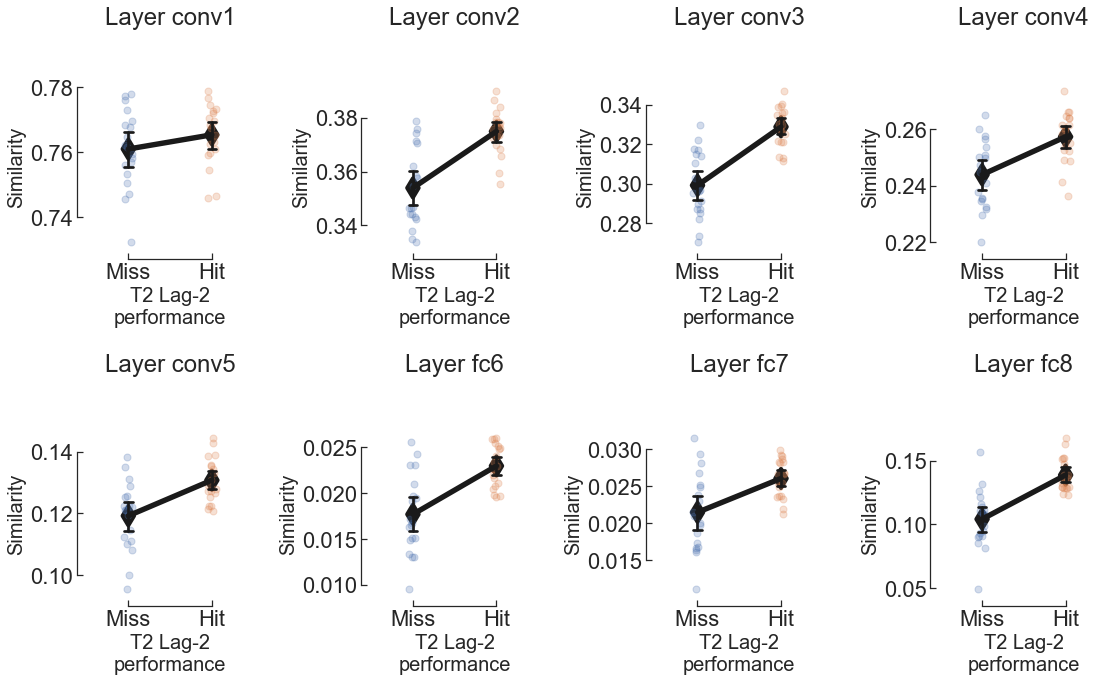

In [23]:
# group data for plotting
df_plot = df2.groupby(['subject', 'HitT2'], as_index=False).mean()

#plt.figure(figsize=(4,5))

fig, axes = plt.subplots(2,4, figsize=(16,10))
axes = axes.ravel()

#layer = 'conv5'
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

stats = []
for i, layer in enumerate(layers):
    # plot individual subjects, with different colors per lag
    # and dashed line between subjects
    ax = axes[i]
    for s in np.unique(df_plot.subject):
        sdf = df_plot[df_plot.subject==s]
        miss = sdf[sdf.HitT2 == 0][f'sim_{layer}'].values[0]
        hit = sdf[sdf.HitT2 == 1][f'sim_{layer}'].values[0]

        jitter = (np.random.randint(100)-50)/1000
        markersize=7
        x = (0+jitter, 1+jitter)
        ax.plot(x[0], miss, color=sns.color_palette()[0], marker='o', alpha=0.25, markersize=markersize)
        ax.plot(x[1], hit, color=sns.color_palette()[1], marker='o', alpha=0.25, markersize=markersize)
        #plt.plot((lag2, lag8),x, '--k', alpha=0.25)

    #plt.setp(ax.lines, zorder=100)
    # plot mean on top of subjects
    g = sns.pointplot(x='HitT2', y=f'sim_{layer}', color='k',
                       data=df_plot, zorder=1, ci=95,
                       capsize=.1, markers="d", scale=2, ax=ax)
    #g.setp(ax.collections, zorder=100, label="")
    #plt.ylim((0.1, 1.0))
    sns.despine(offset=10, trim=True, ax=ax)
    
    # get p-values
    hit = df_plot[df_plot.HitT2==1][f'sim_{layer}'].values
    miss = df_plot[df_plot.HitT2==0][f'sim_{layer}'].values

    t, p = ttest_rel(hit,miss)
    d = cohen_d(hit,miss)
    stats.append({'layer': layer,
                  'mean hit': np.mean(hit),
                  'std hit': np.std(hit),
                  'mean miss': np.mean(miss),
                  'std miss': np.std(miss),
                  'p': p,
                  't': t,
                  'Cohens d':d})
    
    #ax.set_yticks(size=19)
    # Set labels
    ax.set_xlabel('T2 Lag-2\nperformance', size=20)
    ax.set_ylabel(f'Similarity', size=20)
    ax.set_title(f'Layer {layer}\n\n')
    ax.set_xticklabels(('Miss', 'Hit'))


plt.tight_layout()
#plt.show()
save_to = os.path.join(plot_folder, 'similarity_t2_perfomance.pdf')
plt.savefig(save_to)

## Related stats to above

/Users/daniel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


conv1
T 0.904
std 0.046681609571216955
conv2
T 4.637
std 0.044941496996714646
conv3
T 6.027
std 0.04797742780161884
conv4
T 3.208
std 0.04208518543037222
conv5
T 3.146
std 0.041200930018118725
fc6
T 3.698
std 0.044632607307712395
fc7
T 2.886
std 0.03787197025500563
fc8
T 5.818
std 0.04120948592746169


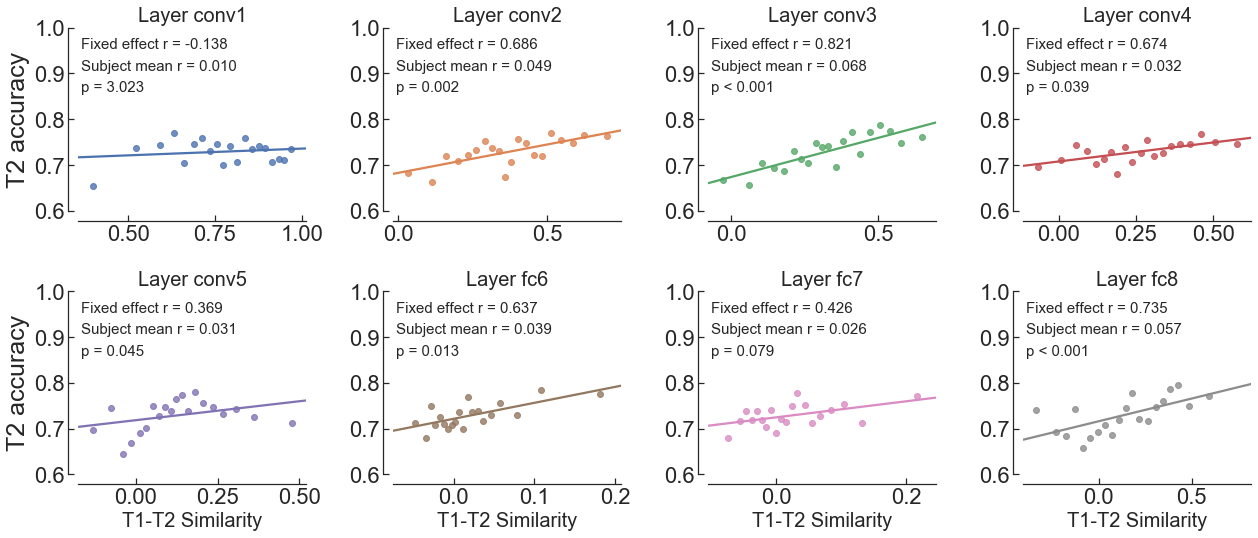

In [22]:
sns.set(style="ticks", font_scale = 2)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
layers = ['conv1','conv2','conv3','conv4','conv5', 'fc6','fc7','fc8', ]
f, ax = plt.subplots(2,4,figsize=(18,8), sharey=True)

ax = ax.ravel()
dframe2 = pd.DataFrame(columns=['subject', 'layer',  'pcorr'])
for x, layer in enumerate(layers):
    
    
    plt_df = df2.groupby(("bins_{0}".format(layer)), as_index=False).mean()
    sns.regplot(x=f"sim_{layer}", y="HitT2", data=plt_df, ax=ax[x], ci=None)
    fr, fp = spearmanr(plt_df[f"sim_{layer}"].values, plt_df["HitT2"].values)
    if x == 0 or x == 4:
        ax[x].set_ylabel('T2 accuracy', size=25)
    else:
        ax[x].set_ylabel('', size=25)
    if x > 3:
        ax[x].set_xlabel('T1-T2 Similarity', size=20)
    else:
        ax[x].set_xlabel('', size=25)
    
    #ax[x].set_xticks(range(1, 21, 5))
    
    # do stats
    df_binned = df2.groupby(("bins_{0}".format(layer), 'subject'), as_index=False).mean()
    r_values = []
    for sub in np.unique(df2.subject):
        tmp = df2[df2.subject == sub]
        r, p = pbs(tmp['HitT2'].values, tmp[f'sim_{layer}'])
        r_values.append(r)
        tmp_df = pd.DataFrame()
        
    #ttest
    t, p = ttest_1samp(np.arctanh(r_values), 0)
    p *= 8
    ax[x].set_title("Layer {0}".format(layer), size=20)
    print(layer)
    print('T', np.around(t, 3))
    # add p-value legend
    handles = [Line2D([0], [0], color='k', lw=0)]*3
    if p < 0.001:
        p_str = f'p < 0.001'
    else:
        p_str = f'p = {p:.3f}'
    rr = np.mean(r_values)
    print('std', np.std(r_values))
    labels = [f'\nFixed effect r = {fr:.3f}',f'Subject mean r = {rr:.3f}', p_str]
    l = ax[x].legend(handles, labels, loc=3,
                    bbox_to_anchor=(-.2, 0.6),
                   borderaxespad=0., frameon=False,
                   prop={'size': 15})
    ax[x].set_ylim(0.6, 1)
    sns.despine(offset=10, ax=ax[x])
#sns.despine()
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.tight_layout()


save_to = os.path.join(plot_folder, f'layer_target_similiarty_T2_{lag}.pdf')
plt.savefig(save_to, bbox_inches='tight')


## Plot heatmap of layer comparisons 

In [23]:
pbs_corr = pd.DataFrame()
for sub in np.unique(df.subject):
    for layer in layers:
        tmp = df2[df2.subject==sub]
        r, p = pbs(tmp['HitT2'].values, tmp[f'sim_{layer}'])
        
        tmp = pd.DataFrame()
        tmp['correlation'] = [r]
        tmp['layer'] = [layer]
        tmp['subject'] = [sub]
        pbs_corr = pd.concat((pbs_corr, tmp))

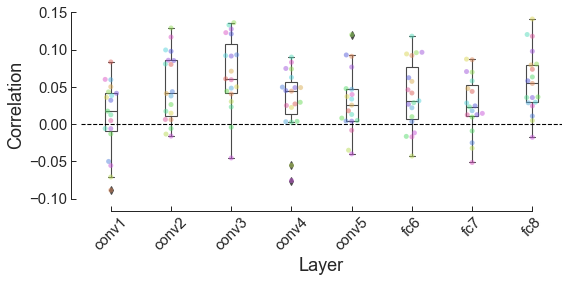

In [24]:
sns.set(style="ticks", font_scale = 2)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
paper_rc = {'lines.linewidth': 1.1, 'lines.markersize': 10}
sns.set_context("paper", rc = paper_rc)
cmap = sns.color_palette("hls", 20)

plt.figure(figsize=(8,4))

# plot
sns.boxplot(x='layer', y='correlation', data=pbs_corr, boxprops={'facecolor':'none'}, width=0.2)
ax = sns.swarmplot(x='layer', y='correlation', hue='subject',
                   data=pbs_corr, palette=cmap, edgecolor='black',
                   alpha=0.5)
ax.legend_.remove()
# add horizontal line at 0
plt.axhline(y=0.0, color='black', linestyle='--')
sns.despine(offset=10, trim=True)

#plt.ylim([-.8, .61])
plt.yticks(size=15)
# Set labels
plt.xlabel('Layer', size=18)
plt.ylabel('Correlation', size=18)
plt.xticks(range(8), layers, size=15, rotation=45)

#plt.title('Correlation between T2 performance and ', size=15)
plt.tight_layout()

# Save
save_to = os.path.join(plot_folder, f'layer_subject_target_similiarty_T2_{lag}.pdf')
plt.savefig(save_to, bbox_inches='tight')

In [212]:
# Save for stats
df_save = dframe2.pivot(index='subject', columns='layer', values='pcorr')
df_save.to_csv(os.path.join(data_folder, 't-t_t2_accuracy_corr.csv'), index=False)

In [58]:
layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']
# define possible layer comparisons
combos = list(itertools.combinations(range(8), 2))
alpha = 0.05
p_vals = np.eye(8)
mean_diff = np.zeros((8,8))
for l1, l2 in combos:
    layerx, layery = layers[l1], layers[l2]
    layerx = pbs_corr[pbs_corr.layer==layerx]['correlation'].values
    layery = pbs_corr[pbs_corr.layer==layery]['correlation'].values
    t, p = ttest_rel(np.arctanh(layerx), np.arctanh(layery))
    p_vals[l1, l2] = p
    mean_diff[l1, l2] = layerx.mean()- layery.mean()

method = 'b'
pval_raw = p_vals[np.triu_indices(8, 1)].flatten()
p_vals[np.triu_indices(8, 1)] = smm.multipletests(pval_raw, alpha=alpha, method=method)[:2][1]

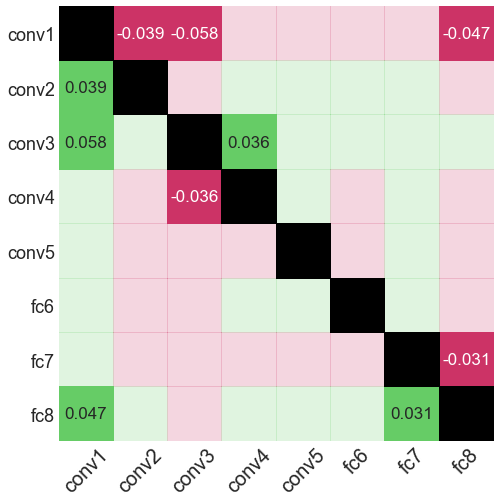

In [59]:
plt.figure(figsize=(10,8))
i_lower = np.tril_indices(8, -1)
i_upper = np.triu_indices(8, 1)

# repeat values of upper triangle on lower triangle
p_vals[i_lower] = p_vals.T[i_lower]
mean_diff[i_lower] = mean_diff.T[i_lower]*-1

# create masks
mask = p_vals > 0.05 #/len(combos) # Bonferroni correct alpha
#mask[i_upper] = True
# the faint color in the background is only masked on the upper triangle
alpha_mask = np.zeros((8,8)).astype(bool)
#alpha_mask[i_upper] = True

# define hot/cold color map
cmap = sns.color_palette("RdBu_r", 2)
cmap = [(0.8, 0.2, 0.4), # green for winning
        (0.4, 0.8, 0.4)] # red for loser

# plot the faint color in the backgroud
ax = sns.heatmap(mean_diff, robust=True, alpha=0.2, cbar=False, square=True,
                 vmin=-0.01, vmax=0.01, cmap=cmap, mask=alpha_mask)
# plot the main results
ax = sns.heatmap(mean_diff , robust=True, cbar=False, vmin=-0.01, square=True,
            vmax=0.01, annot=True, mask=mask, cmap=cmap, annot_kws={"size": 17},
           xticklabels=layers, yticklabels=layers)

# Lets make the diagonal black
cmap = [(0.0, 0.0, 0.0)] # black for the diagonal
sns.heatmap(np.eye(8), robust=True, cbar=False, cmap=cmap, square=True, 
            mask=~np.eye(8).astype(bool), xticklabels=layers, yticklabels=layers)

plt.xticks(rotation=45, size=20)
plt.yticks(rotation=0, size=18)
plt.tick_params(axis='both', which='major', left='off', bottom='off')

# Save
save_to = os.path.join(plot_folder, 'layer_comparison_target_similiarty_T2.pdf')
plt.savefig(save_to, bbox_inches='tight')